# Libraries

In [1]:
# for local import
import sys
if "../../" not in sys.path:
    sys.path.append("../../")

In [2]:
# for working with data
import pandas as pd
import numpy as np
import scipy.sparse

# for visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

# for preprocessing
from src.preprocessing import BasicTextCleaning
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from nltk import ngrams

# for modelling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# for evaluation
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score

# for timing
import time

# Load Data

In [3]:
osf = pd.read_csv("../../data/fake_reviews_dataset.csv")
print("Shape of OFS: ", osf.shape)
# osf.head()
osf

Shape of OFS:  (40432, 4)


,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...
...,...,...,...,...
40427,Clothing_Shoes_and_Jewelry_5,4.0,OR,I had read some reviews saying that this bra r...
40428,Clothing_Shoes_and_Jewelry_5,5.0,CG,I wasn't sure exactly what it would be. It is ...
40429,Clothing_Shoes_and_Jewelry_5,2.0,OR,"You can wear the hood by itself, wear it with ..."
40430,Clothing_Shoes_and_Jewelry_5,1.0,CG,I liked nothing about this dress. The only rea...


# Preprocessing

### Basic Text Cleaning

In [4]:
cleaner = BasicTextCleaning()

In [5]:
try:
    osf_cleaned = pd.read_csv("../../data/cleaned/osf_cleaned.csv")
    osf_cleaned = osf_cleaned.replace(np.nan, '')
except:
    osf_cleaned = pd.DataFrame()
    osf_cleaned['length'] = osf['text_'].apply(lambda x: len(x))
    osf_cleaned['texts'] = cleaner.text_cleaning(osf['text_'])

    ordinal = OrdinalEncoder(categories=[['OR', 'CG']], dtype=int)
    osf_cleaned['labels'] = ordinal.fit_transform(osf[['label']])
    osf_cleaned.to_csv("../../data/cleaned/osf_cleaned.csv", index=False)

In [6]:
from nltk import ngrams

class AvgWord2Vec:
    def __init__(self, vector_size=300, min_count=1, sg=1, ngram_range=(1, 1), window=5, epochs=5, seed=42,
                 quiet=True):
        self.w2v = Word2Vec(vector_size=vector_size, min_count=min_count, sg=sg,
                            window=window, workers=4, seed=seed, epochs=epochs)
        self.min_count = min_count
        self.sg = sg
        self.window = window
        self.seed = seed
        self.vsize = vector_size
        self.epochs = epochs

        self.ngrams = np.arange(ngram_range[0], ngram_range[1]+1, 1)
        self.raw = None
        self.corpus = None
        self.vocabulary_ = None
        self.quiet = quiet

    def _create_ngrams(self, n, X):
        phrases = []
        for sent in X:
            words = sent.split()
            if len(words) >= n:  # Check if words list is not empty
                ngram_list = list(ngrams(words, n))
                phrases.append([" ".join(word) for word in ngram_list])
            else:
                phrases.append([])
        return phrases
    
    def _create_corpus(self, X, update_train=False):
        ngrams_phrases = {}
        for n in self.ngrams:
            phrases = self._create_ngrams(n, X)
            ngrams_phrases[f"{n}"] = phrases
        data = []
        corpus = []
        for n in ngrams_phrases.values():
            if len(data)==0:
                data = n
            data = [data[i] + n[i] for i in range(len(data))]
            corpus.extend(n)
        if update_train:
            self.corpus = corpus
        return data, corpus
    
    # def _avg_sentence_old(self, data):
    #     avg_sentences = []
    #     for sent in data:
    #         if len(sent)!=0:
    #             avg_sentence = np.mean([self.w2v.wv.get_vector(word) for word in sent
    #                                     if word in self.w2v.wv.index_to_key], axis=0)
    #         else:
    #             avg_sentence = np.zeros(self.vsize)
    #         avg_sentences.append(avg_sentence)
    #     return np.array(avg_sentences)
    
    def _avg_sentence(self, sentences):
        w2v_model = self.w2v
        avg_sentences = []
        for sentence in sentences:
            if len(sentence)!=0:
                avg_sentence = np.mean([w2v_model.wv.get_vector(word) for word in sentence
                                        if word in w2v_model.wv.key_to_index], axis=0)
            else:
                avg_sentence = np.zeros(w2v_model.vector_size)
            avg_sentences.append(avg_sentence)
        return np.array(avg_sentences)

    def fit(self, X):
        self.w2v = Word2Vec(vector_size=self.vsize, min_count=self.min_count, sg=self.sg,
                            window=self.window, workers=4, seed=self.seed, epochs=self.epochs)
        self.raw = list(X)
        
        start = time.time()
        corpus = self._create_corpus(update_train=True, X=X)[1]
        durations = time.time() - start
        if not self.quiet:
            print(f'Create corpus: Done in {int(durations//60)}m{int(durations%60)}s')
        
        start = time.time()
        self.w2v.build_vocab(corpus)
        durations = time.time() - start
        if not self.quiet:
            print(f'Build vocab: Done in {int(durations//60)}m{int(durations%60)}s')

        start = time.time()
        self.w2v.train(corpus, total_examples=self.w2v.corpus_count, epochs=self.w2v.epochs)
        durations = time.time() - start
        if not self.quiet:
            print(f'Training : Done in {int(durations//60)}m{int(durations%60)}s')

        self.vocabulary_ = self.w2v.wv.key_to_index

    def fit_transform(self, X):
        self.w2v = Word2Vec(vector_size=self.vsize, min_count=self.min_count, sg=self.sg,
                            window=self.window, workers=4, seed=self.seed, epochs=self.epochs)
        self.raw = list(X)

        start = time.time()
        data, corpus = self._create_corpus(update_train=True, X=X)
        durations = time.time() - start
        if not self.quiet:
            print(f'Create corpus: Done in {int(durations//60)}m{int(durations%60)}s')

        start = time.time()
        self.w2v.build_vocab(corpus)
        durations = time.time() - start
        if not self.quiet:
            print(f'Build vocab: Done in {int(durations//60)}m{int(durations%60)}s')

        start = time.time()
        self.w2v.train(corpus, total_examples=self.w2v.corpus_count, epochs=self.w2v.epochs)
        durations = time.time() - start
        if not self.quiet:
            print(f'Training : Done in {int(durations//60)}m{int(durations%60)}s')

        start = time.time()
        avg_sents = self._avg_sentence(data)
        durations = time.time() - start
        if not self.quiet:
            print(f'Average : Done in {int(durations//60)}m{int(durations%60)}s')

        start = time.time()
        avg_sents_sprs = scipy.sparse.csr_matrix(avg_sents)
        durations = time.time() - start
        if not self.quiet:
            print(f'Sparse : Done in {int(durations//60)}m{int(durations%60)}s')

        return avg_sents_sprs
        
    def transform(self, X):
        start = time.time()
        data = self._create_corpus(update_train=False, X=X)[0]
        durations = time.time() - start
        if not self.quiet:
            print(f'Create corpus: Done in {int(durations//60)}m{int(durations%60)}s')

        start = time.time()
        avg_sents = self._avg_sentence(data)
        durations = time.time() - start
        if not self.quiet:
            print(f'Average : Done in {int(durations//60)}m{int(durations%60)}s')

        start = time.time()
        avg_sents_sprs = scipy.sparse.csr_matrix(avg_sents)
        durations = time.time() - start
        if not self.quiet:
            print(f'Sparse : Done in {int(durations//60)}m{int(durations%60)}s')

        return avg_sents_sprs
    
    def get_feature_names_out(self):
        columns = np.array([f'component_{i+1}' for i in range(self.vsize)])
        return columns

In [7]:
def avg_word2vec(sentences, w2v_model):
    avg_sentences = []
    for sentence in sentences:
        if sentence:
            avg_sentence = np.mean([w2v_model.wv.get_vector(word) for word in sentence if word in w2v_model.wv.key_to_index], axis=0)
        else:
            avg_sentence = np.zeros(w2v_model.vector_size)
        avg_sentences.append(avg_sentence)
    return np.array(avg_sentences)

# def text_extractor(X_train, X_test, extractor):
#     if isinstance(extractor, Word2Vec):
#         vector_size = extractor.vector_size
#         window = extractor.window
#         sg = extractor.sg
#         extractor = Word2Vec(vector_size=vector_size, sg=sg, window=window, min_count=1, workers=5, seed=42)

#         cleaner = BasicTextCleaning()
#         X_train = cleaner.text_cleaning(texts=X_train, methods=['tokenization'])
#         X_test = cleaner.text_cleaning(texts=X_test, methods=['tokenization'])

#         extractor.build_vocab(X_train)
#         extractor.train(X_train, total_examples=extractor.corpus_count, epochs=30)
#         X_train = avg_word2vec(X_train, extractor)
#         X_train = pd.DataFrame(X_train, columns=[str(i) for i in range(extractor.vector_size)])
#         X_test = avg_word2vec(X_test, extractor)
#         X_test = pd.DataFrame(X_test, columns=[str(i) for i in range(extractor.vector_size)])
#     else:
#         X_train = extractor.fit_transform(X_train).toarray()
#         X_test = extractor.transform(X_test).toarray()
#         X_train = pd.DataFrame(X_train, columns=extractor.get_feature_names_out())
#         X_test = pd.DataFrame(X_test, columns=extractor.get_feature_names_out())
    
#     variance = VarianceThreshold()
#     X_train = variance.fit_transform(X_train)
#     X_test = variance.transform(X_test)
#     X_train = pd.DataFrame(X_train, columns=variance.get_feature_names_out())
#     X_test = pd.DataFrame(X_test, columns=variance.get_feature_names_out())

#     return X_train, X_test

def text_extractor(X_train, X_test, extractor):
    X_train = extractor.fit_transform(X_train).toarray()
    X_test = extractor.transform(X_test).toarray()
    X_train = pd.DataFrame(X_train, columns=extractor.get_feature_names_out())
    X_test = pd.DataFrame(X_test, columns=extractor.get_feature_names_out())
    
    # variance = VarianceThreshold()
    # X_train = variance.fit_transform(X_train)
    # X_test = variance.transform(X_test)
    # X_train = pd.DataFrame(X_train, columns=variance.get_feature_names_out())
    # X_test = pd.DataFrame(X_test, columns=variance.get_feature_names_out())

    return X_train, X_test

def feature_selection(X_train, X_test, selector):
    X_train = selector.fit_transform(X_train)
    X_test = selector.transform(X_test)
    X_train = pd.DataFrame(X_train, columns=selector.get_feature_names_out())
    X_test = pd.DataFrame(X_test, columns=selector.get_feature_names_out())
    
    return X_train, X_test

In [8]:
def modelling(model, X_train, y_train, X_test, probability=True):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if probability:
        y_pred_proba = model.predict_proba(X_test)
        return y_pred, y_pred_proba
    return y_pred

def evaluation(y_true, y_pred, y_pred_prob, scoring=['accuracy', 'f1', 'recall', 'precision', 'roc_auc']):
    scores = {'accuracy': accuracy_score,
              'f1': f1_score,
              'recall': recall_score,
              'precision': precision_score,
              'roc_auc': roc_auc_score}
    
    result = {}
    for method in scoring:
        if method == 'roc_auc':
            result[method] = scores[method](y_true, y_pred_prob.T[1])
        else:
            result[method] = scores[method](y_true, y_pred)

    return result

In [9]:
import time

def cross_validation(data, extractor, model=None, selector=None, length_scaler=None,
                     scoring=['accuracy', 'f1', 'recall', 'precision', 'roc_auc'], cv=5,
                     avg_output=True, quiet=True):
    kfolds = KFold(n_splits=cv, shuffle=True, random_state=42)
    indices_folds = kfolds.split(data.iloc[:, :-1], data.iloc[:, -1])
    scores = {method: [] for method in scoring}
    round = 1

    for train_indices, test_indices in indices_folds:
        train_set, test_set = data.iloc[train_indices, :-1], data.iloc[test_indices, :-1]
        y_train, y_test = data.iloc[train_indices, -1], data.iloc[test_indices, -1]

        start = time.time()
        X_train, X_test = text_extractor(X_train=train_set['texts'], X_test=test_set['texts'], extractor=extractor)
        durations = time.time() - start
        if not quiet:
            print(f"round {round}:")
            print(f'\tText extraction: Done in {int(durations//60)}m{int(durations%60)}s')

        start = time.time()
        if length_scaler is not None:
            X_train['length'] = length_scaler.fit_transform(train_set[['length']])
            X_test['length'] = length_scaler.transform(test_set[['length']])
        durations = time.time() - start
        if not quiet:
            print(f'\tLength scale: Done in {int(durations//60)}m{int(durations%60)}s')
        
        start = time.time()
        if selector is not None:
            X_train, X_test = feature_selection(X_train, X_test, selector)
        durations = time.time() - start
        if not quiet:
            print(f'\tDimensionality reduction: Done in {int(durations//60)}m{int(durations%60)}s')

        start = time.time()
        y_pred, y_pred_prob = modelling(model, X_train, y_train, X_test)
        if not quiet:
            print(f'\tModelling: Done in {int(durations//60)}m{int(durations%60)}s')

        start = time.time()
        result = evaluation(y_true=y_test, y_pred=y_pred, y_pred_prob=y_pred_prob, scoring=scoring)
        for method in scoring:
            scores[method].append(result[method])
        if not quiet:
            print(f'\tEvaluation: Done in {int(durations//60)}m{int(durations%60)}s', end="\n\n")

        round += 1
        
    if avg_output:
        avg_scores = {key: np.mean(values) for key, values in scores.items()}

    return avg_scores

In [10]:
models = {'1': 0, '2': 2}
scoring=['accuracy', 'f1', 'recall', 'precision', 'roc_auc']
output = {model: {score: [] for score in scoring} for model in models.keys()}
output

{'1': {'accuracy': [], 'f1': [], 'recall': [], 'precision': [], 'roc_auc': []},
 '2': {'accuracy': [], 'f1': [], 'recall': [], 'precision': [], 'roc_auc': []}}

In [11]:
import time

def multi_cross_validation(data, extractor, models=None, selector=None, length_scaler=None,
                           scoring=['accuracy', 'f1', 'recall', 'precision', 'roc_auc'], cv=5, quiet=True):
    kfolds = KFold(n_splits=cv, shuffle=True, random_state=42)
    indices = kfolds.split(data.iloc[:, :-1], data.iloc[:, -1])
    output = {model: {score: [] for score in scoring} for model in models.keys()}
    round = 1

    for train_indices, test_indices in indices:
        if not quiet:
          print(f"round {round}:")

        train_set, test_set = data.iloc[train_indices, :-1], data.iloc[test_indices, :-1]
        y_train, y_test = data.iloc[train_indices, -1], data.iloc[test_indices, -1]

        start = time.time()
        X_train, X_test = text_extractor(X_train=train_set['texts'], X_test=test_set['texts'], extractor=extractor)
        durations = time.time() - start
        if not quiet:
            print(f'\tText extraction: Done in {int(durations//60)}m{int(durations%60)}s')

        start = time.time()
        if length_scaler is not None:
            X_train['length'] = length_scaler.fit_transform(train_set[['length']])
            X_test['length'] = length_scaler.transform(test_set[['length']])
        durations = time.time() - start
        if not quiet:
            print(f'\tLength scale: Done in {int(durations//60)}m{int(durations%60)}s')

        start = time.time()
        if selector is not None:
            X_train, X_test = feature_selection(X_train, X_test, selector)
        durations = time.time() - start
        if not quiet:
            print(f'\tDimensionality reduction: Done in {int(durations//60)}m{int(durations%60)}s')

        for key, model in models.items():
            start = time.time()
            y_pred, y_pred_prob = modelling(model, X_train, y_train, X_test)
            durations = time.time() - start
            if not quiet:
                print(f'\t{key} - Modelling: Done in {int(durations//60)}m{int(durations%60)}s')

            start = time.time()
            result = evaluation(y_true=y_test, y_pred=y_pred, y_pred_prob=y_pred_prob, scoring=scoring)
            for method in scoring:
                output[key][method].append(result[method])
            durations = time.time() - start
            if not quiet:
                print(f'\tEvaluation: Done in {int(durations//60)}m{int(durations%60)}s')
        if not quiet:
            print()
        round += 1

    for model_name, model_scores in output.items():
        output[model_name] = {key: np.mean(values) for key, values in model_scores.items()}

    return output

In [ ]:
import time

def multi_cross_validation_new(data, extractor, models=None, selector=None, length_scalers=None,
                           scoring=['accuracy', 'f1', 'recall', 'precision', 'roc_auc'], cv=5, quiet=True):
    kfolds = KFold(n_splits=cv, shuffle=True, random_state=42)
    indices = kfolds.split(data.iloc[:, :-1], data.iloc[:, -1])]
    output = {model: {score: [] for score in scoring} for model in models.keys()}
    output = {length: {model: {score: [] for score in scoring} for model in models.keys()} for length in length_scalers}
    round = 1

    for train_indices, test_indices in indices:
        if not quiet:
          print(f"round {round}:")

        train_set, test_set = data.iloc[train_indices, :-1], data.iloc[test_indices, :-1]
        y_train, y_test = data.iloc[train_indices, -1], data.iloc[test_indices, -1]

        start = time.time()
        X_train, X_test = text_extractor(X_train=train_set['texts'], X_test=test_set['texts'], extractor=extractor)
        durations = time.time() - start
        if not quiet:
            print(f'\tText extraction: Done in {int(durations//60)}m{int(durations%60)}s')
        
        for length_scaler in length_scalers:
            start = time.time()
            if length_scaler is not None:
                X_train['length'] = length_scaler.fit_transform(train_set[['length']])
                X_test['length'] = length_scaler.transform(test_set[['length']])
            durations = time.time() - start
            if not quiet:
                print(f'\tLength scale: Done in {int(durations//60)}m{int(durations%60)}s')

            start = time.time()
            if selector is not None:
                X_train, X_test = feature_selection(X_train, X_test, selector)
            durations = time.time() - start
            if not quiet:
                print(f'\tDimensionality reduction: Done in {int(durations//60)}m{int(durations%60)}s')

            for model_name, model in models.items():
                start = time.time()
                y_pred, y_pred_prob = modelling(model, X_train, y_train, X_test)
                durations = time.time() - start
                if not quiet:
                    print(f'\t{model_name} - Modelling: Done in {int(durations//60)}m{int(durations%60)}s')

                start = time.time()
                result = evaluation(y_true=y_test, y_pred=y_pred, y_pred_prob=y_pred_prob, scoring=scoring)
                for method in scoring:
                    output[length_scaler][model_name][method].append(result[method])
                durations = time.time() - start
                if not quiet:
                    print(f'\tEvaluation: Done in {int(durations//60)}m{int(durations%60)}s')
        if not quiet:
            print()
        round += 1

    for length, result in output.items():
        for model_name, model_scores in result.items():
            output[length][model_name] = {key: np.mean(values) for key, values in model_scores.items()}

    return output

In [12]:
# extractor = AvgWord2Vec(window=10, vector_size=300, seed=42, sg=1, ngram_range=(1, 1), epochs=15)
# model = LogisticRegression(max_iter=1000, class_weight="balanced")
# # model = SVC(probability=True, class_weight='balanced')
# # extractor = TfidfVectorizer(min_df=0.001, ngram_range=(1, 1))
# # model = SVC()

# cross_validation(data=osf_cleaned, length_scaler=None,
#                  model=model, extractor=extractor, quiet=False)

In [13]:
def preprocessing(X_train, X_test, extractor, length_scaler=None, selector=None, quiet=True):
    start = time.time()
    X_train_final, X_test_final = text_extractor(X_train=X_train['texts'], X_test=X_train['texts'],
                                                 extractor=extractor)
    durations = time.time() - start
    if not quiet:
        print(f'Text extraction: Done in {int(durations//60)}m{int(durations%60)}s')

    start = time.time()
    if length_scaler is not None:
        X_train_final['length'] = length_scaler.fit_transform(X_train[['length']])
        X_test_final['length'] = length_scaler.transform(X_test[['length']])
    durations = time.time() - start
    if not quiet:
        print(f'Length scale: Done in {int(durations//60)}m{int(durations%60)}s')

    start = time.time()
    if selector is not None:
        X_train_final, X_test_final = feature_selection(X_train_final, X_test_final, selector)
    durations = time.time() - start
    if not quiet:
        print(f'Dimensionality reduction: Done in {int(durations//60)}m{int(durations%60)}s')

    return X_train_final, X_test_final

1. vector 700, epochs 15
`{'accuracy': 0.8653293589522868,
 'f1': 0.8659835174302151,
 'recall': 0.8704120110872922,
 'precision': 0.8616035385960963,
 'roc_auc': 0.9281436268183738}`

# Define Testcases

### Testing for Different Window Sizes
<br>
Test if window size affect the performance of Word2Vec skipgrams and cbow.

* window size range (1, 21, 2)
* fixed other components
    * no length used nor feature selector
    * text Extractor: `AvgWord2Vec(vector_size=100, ngram_range=(1, 1))`
    * model: `LogisticRegression(max_iter=1000, class_weight='balanced)`

In [11]:
output = {'window': [],
          'w2v_type': [],
          'accuracy': [],
          'f1': [],
          'recall': [],
          'precision': [],
          'roc_auc': []}

for sg in [1]:
    for window in range(12, 16, 1):
        scores = cross_validation(data=osf_cleaned,
                                  extractor=AvgWord2Vec(vector_size=300, window=window, sg=sg),
                                  model=LogisticRegression(max_iter=1000, class_weight="balanced"))
        output['window'].append(window)
        output['w2v_type'].append('cbow' if sg==0 else 'skipgram')
        for key, value in scores.items():
            output[key].append(value)
        print(f"{output['w2v_type'][-1]} - window {window}: done")

skipgram - window 12: done
skipgram - window 13: done
skipgram - window 14: done
skipgram - window 15: done


In [14]:
# output_df = pd.DataFrame(output)
# output_df
# output_saved = pd.read_csv("../../output/define_testcases/w2v_window_test.csv")
# output_saved
# output_new = pd.concat([output_saved, output_df], axis=0, ignore_index=True)
# output_new
# # output_new.to_csv("../../output/define_testcases/w2v_window_test.csv", index=False)

In [23]:
# # save file from other sources
# output_outsource = pd.read_csv(r"C:\Users\minhn\Downloads\r2_w2v_window_test_ggcolab_2.csv")
# output_saved = pd.read_csv("../../output/define_testcases/w2v_window_test.csv")
# output_saved
# output_new = pd.concat([output_saved.iloc[:15], output_outsource, output_saved.iloc[15:]], axis=0, ignore_index=True)
# output_new
# output_new.to_csv("../../output/define_testcases/w2v_window_test.csv", index=False)

__Visualization__

In [24]:
window_size = pd.read_csv(r"..\..\output\define_testcases\w2v_window_test.csv")
window_size

,window,w2v_type,accuracy,f1,recall,precision,roc_auc
0,1,cbow,0.825262,0.827133,0.836307,0.818180,0.888993
1,2,cbow,0.828749,0.830358,0.838395,0.822491,0.893035
2,3,cbow,0.831841,0.833240,0.840415,0.826206,0.895036
3,4,cbow,0.834685,0.836149,0.843814,0.828629,0.897175
4,5,cbow,0.835600,0.836963,0.844122,0.829936,0.898960
5,6,cbow,0.836565,0.837800,0.844354,0.831360,0.899589
6,7,cbow,0.836986,0.838204,0.844702,0.831812,0.899824
7,8,cbow,0.837604,0.838802,0.845193,0.832507,0.901309
8,9,cbow,0.838692,0.839756,0.845501,0.834097,0.901779
9,10,cbow,0.838000,0.838923,0.843915,0.833994,0.901666


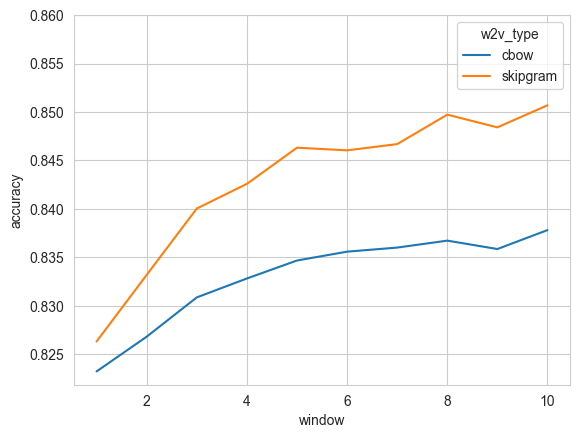

In [15]:
window_size = pd.read_csv(r"..\..\output\define_testcases\w2v_window_test_vs100.csv")
sns.lineplot(x=window_size['window'], y=window_size['accuracy'], hue=window_size['w2v_type'])
plt.ylim(top=0.86)
# plt.xticks(range(1, 21, 1))
plt.show()

### Testing for Different Vector Sizes
<br>
Test if window size affect the performance of Word2Vec skipgrams and cbow.

* window size range (1, 21, 2)
* fixed other components
    * no length used nor feature selector
    * text Extractor: `AvgWord2Vec(vector_size=100, ngram_range=(1, 1))`
    * model: `LogisticRegression(max_iter=1000, class_weight='balanced)`

In [10]:
output = {'vector_size': [],
          'w2v_type': [],
          'accuracy': [],
          'f1': [],
          'recall': [],
          'precision': [],
          'roc_auc': []}

for sg in [1]:
    for vector in range(900, 1100, 100):
        scores = cross_validation(data=osf_cleaned,
                                  extractor=AvgWord2Vec(vector_size=vector, window=10, sg=sg),
                                  model=LogisticRegression(max_iter=1000, class_weight="balanced"))
        output['vector_size'].append(vector)
        output['w2v_type'].append('cbow' if sg==0 else 'skipgram')
        for key, value in scores.items():
            output[key].append(value)
        print(f"{output['w2v_type'][-1]} - vector {vector}: done")

skipgram - vector 900: done
skipgram - vector 1000: done


In [12]:
# output_df = pd.DataFrame(output)
# output_saved = pd.read_csv("../../output/define_testcases/w2v_vectorsize_test.csv")
# output_saved
# output_new = pd.concat([output_saved, output_df], axis=0)
# output_new
# output_new.to_csv("../../output/define_testcases/w2v_vectorsize_test.csv", index=False)

In [18]:
# # save file from other sources
# output_outsource = pd.read_csv(r"C:\Users\minhn\Downloads\r2_w2v_vectorsize_test_kaggle_1.csv")
# output_saved = pd.read_csv("../../output/define_testcases/w2v_vectorsize_test.csv")
# output_saved
# output_new = pd.concat([output_outsource, output_saved], axis=0, ignore_index=True)
# output_new
# # output_new.to_csv("../../output/define_testcases/w2v_vectorsize_test.csv", index=False)

__Visualization__

In [19]:
vector_size = pd.read_csv(r"..\..\output\define_testcases\w2v_vectorsize_test.csv")
vector_size

,vector_size,w2v_type,accuracy,f1,recall,precision,roc_auc
0,100,cbow,0.837703,0.838745,0.844355,0.833211,0.901490
1,200,cbow,0.840052,0.840881,0.845566,0.836254,0.902593
2,300,cbow,0.838469,0.839506,0.845107,0.833985,0.902159
3,400,cbow,0.838346,0.839283,0.844385,0.834246,0.901508
4,500,cbow,0.837208,0.838164,0.843354,0.833048,0.901603
5,600,cbow,0.836837,0.837860,0.843323,0.832477,0.900597
6,700,cbow,0.837455,0.838505,0.844198,0.832892,0.900810
7,800,cbow,0.837851,0.838951,0.844930,0.833060,0.900736
8,900,cbow,0.836985,0.838010,0.843552,0.832549,0.900453
9,1000,cbow,0.836046,0.837040,0.842363,0.831794,0.900172


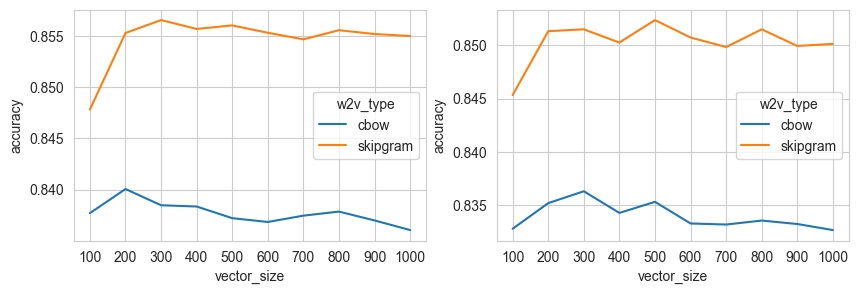

In [12]:
vector_size1 = pd.read_csv(r"..\..\output\define_testcases\w2v_vectorsize_test.csv")

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
sns.lineplot(x=vector_size1['vector_size'], y=vector_size1['accuracy'], hue=vector_size1['w2v_type'])
# plt.ylim(bottom=0.83, top=0.86)
plt.xticks(range(100, 1100, 100))

vector_size2 = pd.read_csv(r"..\..\output\define_testcases\w2v_vectorsize_test_old.csv")
plt.subplot(1, 2, 2)
sns.lineplot(x=vector_size2['vector_size'], y=vector_size2['accuracy'], hue=vector_size2['w2v_type'])
# plt.ylim(bottom=0.83, top=0.86)
plt.xticks(range(100, 1100, 100))
plt.show()

In [13]:
avg_vectorsize = vector_size1.iloc[:, :2].copy()
for col in vector_size1.columns[2:]:
    avg_vectorsize[col] = np.mean([vector_size1[col], vector_size2[col]], axis=0)
avg_vectorsize

,vector_size,w2v_type,accuracy,f1,recall,precision,roc_auc
0,100,cbow,0.835254,0.836417,0.842551,0.830386,0.898750
1,200,cbow,0.837629,0.838690,0.844462,0.833006,0.900784
2,300,cbow,0.837394,0.838485,0.844358,0.832703,0.900264
3,400,cbow,0.836318,0.837422,0.843367,0.831570,0.899812
4,500,cbow,0.836268,0.837340,0.843106,0.831663,0.899769
5,600,cbow,0.835069,0.836247,0.842454,0.830142,0.898509
6,700,cbow,0.835328,0.836467,0.842515,0.830510,0.898940
7,800,cbow,0.835712,0.836971,0.843629,0.830425,0.898994
8,900,cbow,0.835118,0.836289,0.842472,0.830205,0.898630
9,1000,cbow,0.834364,0.835604,0.842099,0.829220,0.898476


<Axes: xlabel='vector_size', ylabel='accuracy'>

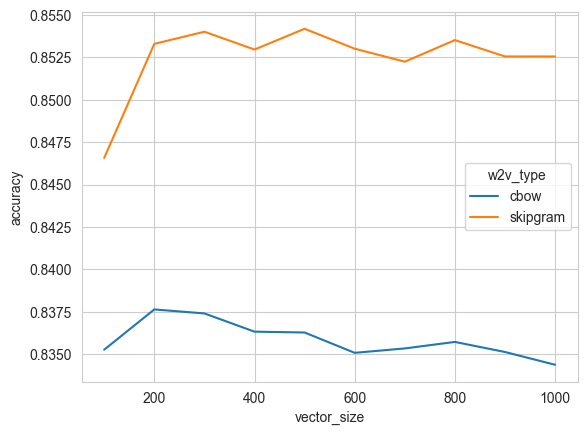

In [14]:
sns.lineplot(x=avg_vectorsize['vector_size'], y=avg_vectorsize['accuracy'], hue=avg_vectorsize['w2v_type'])
# plt.ylim(bottom=0.83, top=0.86)
# plt.xticks(range(100, 1100, 100))

### Testing for Different Epochs

In [10]:
import time

output = {'epochs': [],
          'w2v_type': [],
          'accuracy': [],
          'f1': [],
          'recall': [],
          'precision': [],
          'roc_auc': []}

for sg in [1]:
    for epochs in range(35, 45, 5):
        start = time.time()
        scores = cross_validation(data=osf_cleaned,
                                  extractor=AvgWord2Vec(vector_size=300, window=5, sg=sg, epochs=epochs),
                                  model=LogisticRegression(max_iter=1000, class_weight="balanced"))
        output['epochs'].append(epochs)
        output['w2v_type'].append('cbow' if sg==0 else 'skipgram')
        for key, value in scores.items():
            output[key].append(value)
        durations = time.time() - start
        print(f"{output['w2v_type'][-1]} - epochs {epochs}: {int(durations//60)}m{int(durations%60)}s")

skipgram - epochs 35: 46m18s


KeyboardInterrupt: 

In [16]:
# output_df = pd.DataFrame(output)
# output_saved = pd.read_csv("../../output/define_testcases/w2v_epochs_test.csv")
# output_saved
# output_new = pd.concat([output_saved, output_df], axis=0, ignore_index=True)
# output_new
# output_new.to_csv("../../output/define_testcases/w2v_epochs_test.csv", index=False)

In [24]:
# # save file from other sources
output_outsource = pd.read_csv(r"C:\Users\minhn\Downloads\w2v_epochs_test_ggcolab_5.csv")
output_outsource.loc[4, :] = {'epochs': 1,
                              'w2v_type': 2,
                              'accuracy': 1,
                              'f1': 1,
                              'recall': 2,
                              'precision': 0,
                              'roc_auc': 9}
output_outsource
# output_saved = pd.read_csv("../../output/define_testcases/w2v_epochs_test.csv")
# output_saved.iloc[:6]
# output_new = pd.concat([output_saved.iloc[:6, :], output_outsource, output_saved.iloc[6:, :]], axis=0, ignore_index=True)
# output_new
# output_new.to_csv("../../output/define_testcases/w2v_epochs_test.csv", index=False)

,epochs,w2v_type,accuracy,f1,recall,precision,roc_auc
0,35.0,cbow,0.859666,0.860621,0.866707,0.854621,0.921685
1,40.0,cbow,0.859443,0.860417,0.866612,0.854311,0.921945
2,45.0,cbow,0.858899,0.859849,0.865820,0.853965,0.922244
3,50.0,cbow,0.858132,0.859090,0.865077,0.853189,0.921439
4,1.0,2,1.000000,1.000000,2.000000,0.000000,9.000000


__Visualization__

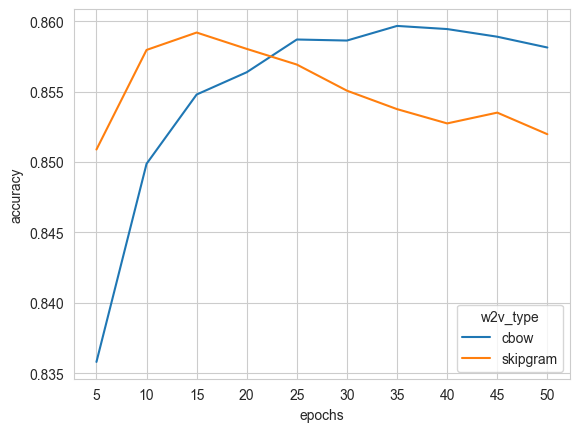

In [17]:
epochs_sizes = pd.read_csv(r"..\..\output\define_testcases\w2v_epochs_test.csv")
sns.lineplot(x=epochs_sizes['epochs'], y=epochs_sizes['accuracy'], hue=epochs_sizes['w2v_type'])
# plt.ylim(top=0.86)
plt.xticks(range(5, 55, 5))
plt.show()

### Testing for Different Epochs and Vector Sizes

In [14]:
import time

output = {'vector_sizes': [],
          'epochs': [],
          'w2v_type': [],
          'accuracy': [],
          'f1': [],
          'recall': [],
          'precision': [],
          'roc_auc': []}

for sg in [1]:
    for vector_size in range(900, 910, 100):
        for epochs in range(50, 55, 5):
            start = time.time()
            scores = cross_validation(data=osf_cleaned,
                                      extractor=AvgWord2Vec(vector_size=vector_size, window=10, sg=sg, epochs=epochs),
                                      model=LogisticRegression(max_iter=1000, class_weight="balanced"))
            output['vector_sizes'].append(vector_size)
            output['epochs'].append(epochs)
            output['w2v_type'].append('cbow' if sg==0 else 'skipgram')
            for key, value in scores.items():
                output[key].append(value)
            durations = time.time() - start
            print(f"{output['w2v_type'][-1]} - vector {vector_size} - epochs {epochs}: {int(durations//60)}m{int(durations%60)}s")

skipgram - vector 900 - epochs 50: 74m56s


In [17]:
# output_df = pd.DataFrame(output)
# output_df
# output_df.to_csv(r"..\..\output\w2v_sg_vsize_epochs_temp_2.csv", index=False)

In [17]:
# output_df = pd.DataFrame(output)
# output_df
# output_saved = pd.read_csv(r"..\..\output\w2v_sg_vsize_epochs.csv")
# output_saved
# output_new = pd.concat([output_saved.iloc[:51, :], output_df, output_saved.iloc[51:, :]], axis=0, ignore_index=True)
# output_new
# output_new.to_csv(r"..\..\output\w2v_sg_vsize_epochs.csv", index=False)

,vector_sizes,epochs,w2v_type,accuracy,f1,recall,precision,roc_auc
0,300,5,skipgram,0.855535,0.856331,0.861251,0.851499,0.918775
1,300,10,skipgram,0.859567,0.860108,0.863619,0.856649,0.923026
2,300,15,skipgram,0.859888,0.860490,0.864362,0.856667,0.922474
3,300,20,skipgram,0.858948,0.859437,0.862501,0.856406,0.921357
4,300,25,skipgram,0.856896,0.857294,0.859871,0.854759,0.919477
5,300,30,skipgram,0.855882,0.856162,0.858023,0.854318,0.918801
6,300,35,skipgram,0.855585,0.855789,0.857160,0.854450,0.917794
7,300,40,skipgram,0.854398,0.854597,0.855951,0.853259,0.917412
8,300,45,skipgram,0.853755,0.853689,0.853487,0.853912,0.916432
9,300,50,skipgram,0.854249,0.854237,0.854369,0.854123,0.916584


In [16]:
# output_df = pd.DataFrame(output)
# output_df
# output_saved = pd.read_csv(r"..\..\output\w2v_vsize_epochs.csv")
# output_saved
# output_new = pd.concat([output_saved, output_df], axis=0, ignore_index=True)
# output_new
# output_new.to_csv(r"..\..\output\w2v_vsize_epochs.csv", index=False)

In [155]:
# # # # save file from other sources
# output_outsource = pd.read_csv(r"C:\Users\minhn\Downloads\sg_1000_40.csv")
# output_outsource
output_saved = pd.read_csv("..\..\output\w2v_sg_vsize_epochs.csv")
output_saved
# output_new = pd.concat([output_saved.iloc[:97, :], output_outsource, output_saved.iloc[97:, :]], axis=0, ignore_index=True)
# output_new.tail(50)
# output_new.to_csv("..\..\output\w2v_sg_vsize_epochs.csv", index=False)

,vector_sizes,epochs,w2v_type,accuracy,f1,recall,precision,roc_auc
0,100,5,skipgram,0.849204,0.850078,0.855201,0.845024,0.913077
1,100,10,skipgram,0.851529,0.852413,0.857739,0.847182,0.914221
2,100,15,skipgram,0.850984,0.851745,0.856228,0.847335,0.913724
3,100,20,skipgram,0.850984,0.851495,0.854494,0.848541,0.913607
4,100,25,skipgram,0.851157,0.851482,0.853443,0.849542,0.912035
...,...,...,...,...,...,...,...,...
95,1000,30,skipgram,0.868149,0.868548,0.871467,0.865662,0.928882
96,1000,35,skipgram,0.867283,0.867767,0.871131,0.864437,0.928865
97,1000,40,skipgram,0.869386,0.869799,0.872767,0.866864,0.928361
98,1000,45,skipgram,0.866739,0.867153,0.870089,0.864247,0.927714


In [24]:
# # # save file from other sources
# output_outsource = pd.read_csv(r"C:\Users\minhn\Downloads\w2v_sg_vsize_epochs_kaggle_3 (1).csv")
# output_outsource
# output_saved = pd.read_csv("..\..\output\w2v_sg_vsize_epochs.csv")
# output_saved
# output_new = pd.concat([output_saved, output_outsource], axis=0, ignore_index=True)
# output_new
# # output_new.to_csv("..\..\output\w2v_sg_vsize_epochs.csv", index=False)

<Axes: xlabel='vector_sizes', ylabel='accuracy'>

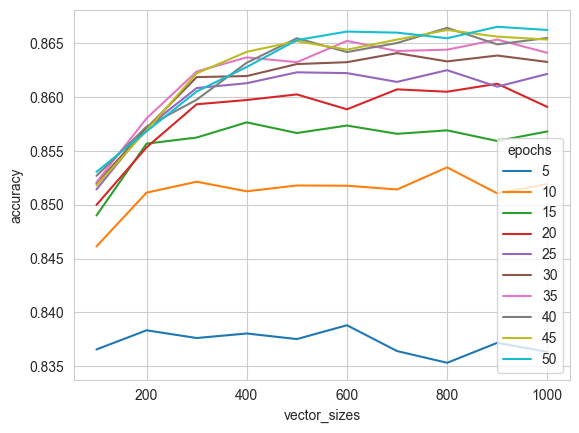

In [14]:
cbow = pd.read_csv("..\..\output\w2v_cbow_vsize_epochs.csv")
cbow_temp = cbow
sns.lineplot(x=cbow_temp['vector_sizes'], y=cbow_temp['accuracy'], hue=cbow_temp['epochs'], palette="tab10")

<Axes: xlabel='epochs', ylabel='accuracy'>

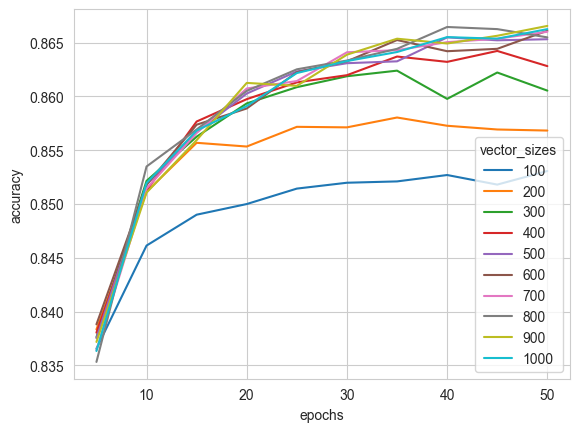

In [15]:
cbow = pd.read_csv("..\..\output\w2v_cbow_vsize_epochs.csv")
cbow_temp = cbow
sns.lineplot(hue=cbow_temp['vector_sizes'], y=cbow_temp['accuracy'], x=cbow_temp['epochs'], palette="tab10")

<Axes: xlabel='vector_sizes', ylabel='accuracy'>

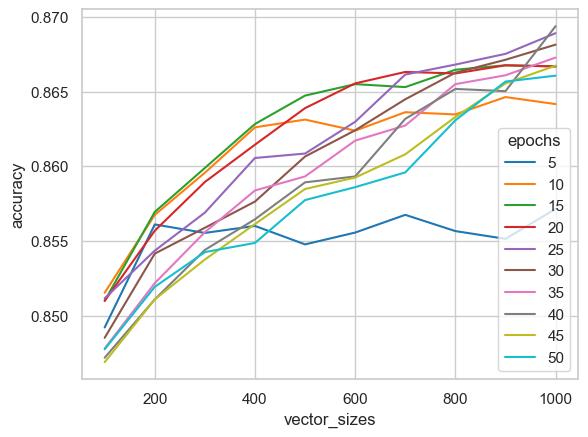

In [162]:
sg = pd.read_csv("..\..\output\w2v_sg_vsize_epochs.csv")
sg_temp = sg.loc[(sg['vector_sizes']>200) & (sg['epochs']>15)].copy()
sg_temp = sg[sg['accuracy']>0.86]
sg_temp = sg[sg['epochs']<35]
sg_temp = sg[sg['vector_sizes']>200]
sg_temp = sg
sns.lineplot(x=sg_temp['vector_sizes'], y=sg_temp['accuracy'], hue=sg_temp['epochs'], palette="tab10")

(0.835, 0.87)

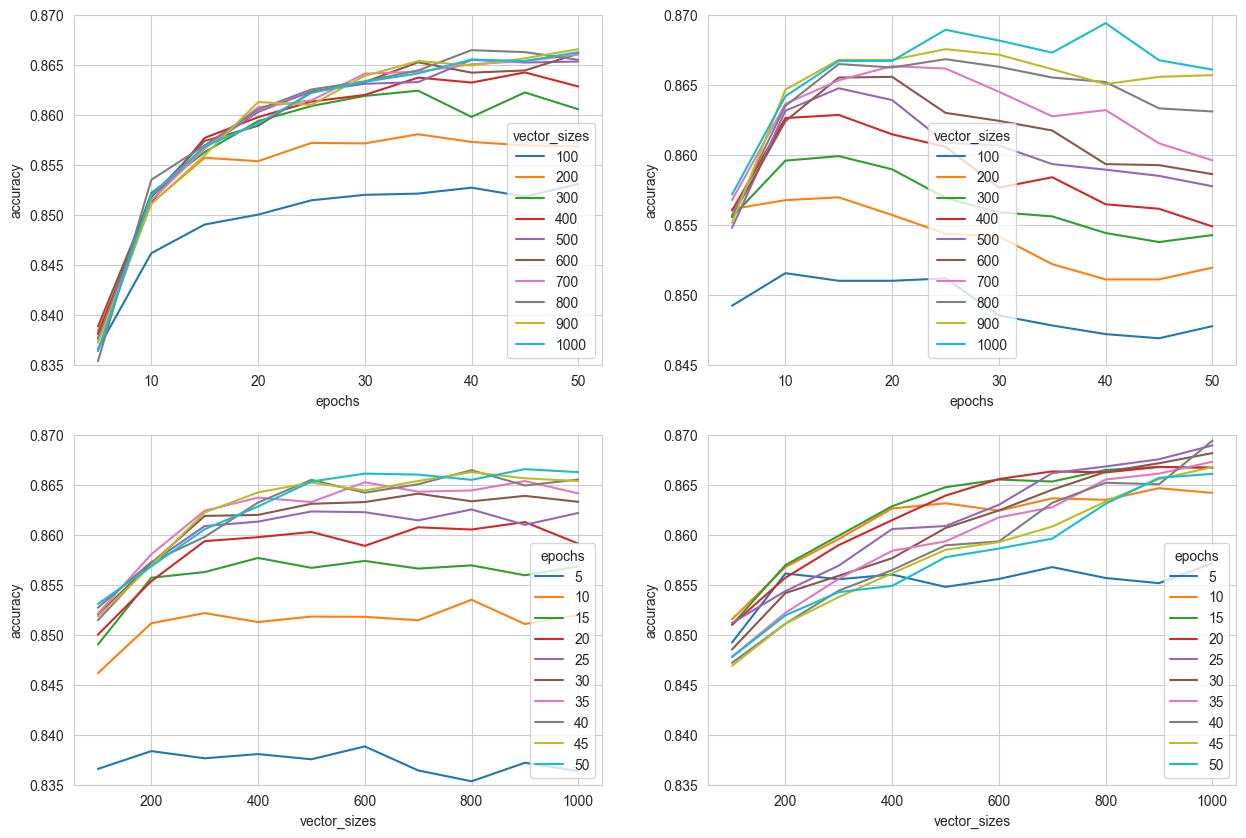

In [70]:
cbow = pd.read_csv("..\..\output\w2v_cbow_vsize_epochs.csv")
# cbow = cbow.loc[(cbow['vector_sizes']<=500) & (cbow['epochs']<=30)]
sg = pd.read_csv("..\..\output\w2v_sg_vsize_epochs.csv")
# sg = sg.loc[(sg['vector_sizes']<=500) & (sg['epochs']<=30)]

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.lineplot(hue=cbow['vector_sizes'], y=cbow['accuracy'], x=cbow['epochs'], palette="tab10")
plt.ylim(top=0.87, bottom=0.835)

plt.subplot(2, 2, 3)
sns.lineplot(x=cbow['vector_sizes'], y=cbow['accuracy'], hue=cbow['epochs'], palette="tab10")
plt.ylim(top=0.87, bottom=0.835)

plt.subplot(2, 2, 2)
sns.lineplot(hue=sg['vector_sizes'], y=sg['accuracy'], x=sg['epochs'], palette="tab10")
plt.ylim(top=0.87, bottom=0.845)

plt.subplot(2, 2, 4)
sns.lineplot(x=sg['vector_sizes'], y=sg['accuracy'], hue=sg['epochs'], palette="tab10")
plt.ylim(top=0.87, bottom=0.835)

__COMMENTS__
<br>
* CBOW:
    * Đối với hầu hết các epochs trong khoảng từ 5 đến 50, accuracy sẽ tăng dần khi vector sizes tăng và tốc độ tăng có xu hướng giảm dần hoặc hầu như chững lại khi vector size đạt đến 30
    * Đối với hầu hết các vector sizes trong khoảng từ 100 đến 1000, accuracy sẽ tăng dần khi epochs tăng nhưng tốc độ tăng chậm dần hoặc gần như chững lại khi epochs đạt đến 30.
    * Ngoại trừ các vector size từ 100 đến 400, các vector size còn lại gần như share chung 1 pattern khi được train với cùng một epochs
    <br>
    &rarr; Để balance giữa accuracy và computational cost, chọn test cbow với vector size = 300 và epochs 30

* Skip-gram:
    * Đối với hầu hết các epochs trong khoảng từ 5 đến 50, accuracy sẽ tăng dần khi vector sizes tăng nhưng tốc độ tăng lại có xu hướng giảm dần hoặc hầu như chững lại khi vector size đạt trong khoảng từ 600 đến 800 (epochs nhỏ hơn hoặc bằng 20 đạt ổn định khi đạt 600 và trên 20 đạt ổn định khi vector size đạt 800)
    * Đối với hầu hết các vector sizes trong khoảng từ 100 đến 1000, accuracy sẽ tăng dần khi epochs tăng và sau đó giảm dần khi epochs đạt trong khoảng từ 10 đến 30 (chỉ ngoại trừ vector size = 1000), cụ thể là accracy của các vector dưới 700 bắt đầu giảm khi epochs đạt 15 và accuracy của vector size từ 700 đến 900 sẽ bắt đầu giảm khi epochs đạt 25
    * Ngoại trừ các vector size từ 100 đến 400, các vector size còn lại gần như share chung 1 pattern khi được train với cùng một epochs
    <br>
    &rarr; Để balance giữa accuracy và computational cost, chọn test skipgram với vector size = 600 và epochs 15

&rarr; Dường như độ lớn của vector size ảnh hướng nhiều đến performance của skipgram model hơn còn số lượng epochs sẽ ảnh hưởng nhiều đến performance của cbow model hơn.

<Axes: xlabel='epochs'>

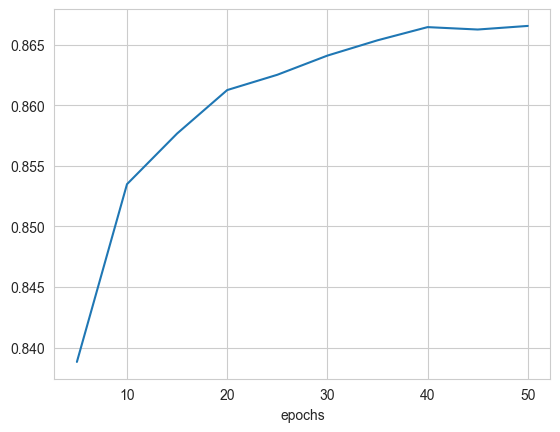

In [54]:
cbow_epochs_max = cbow.groupby("epochs")['accuracy'].max()
sns.lineplot(x=cbow_epochs_max.index, y=cbow_epochs_max.values)

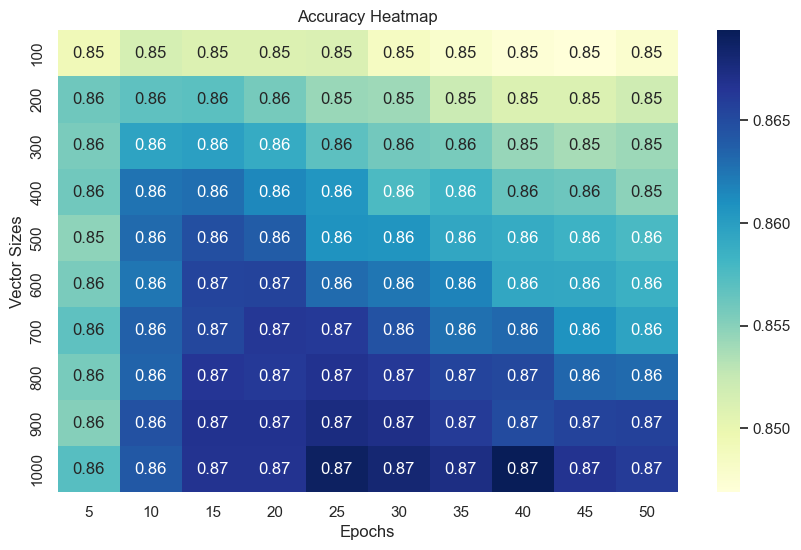

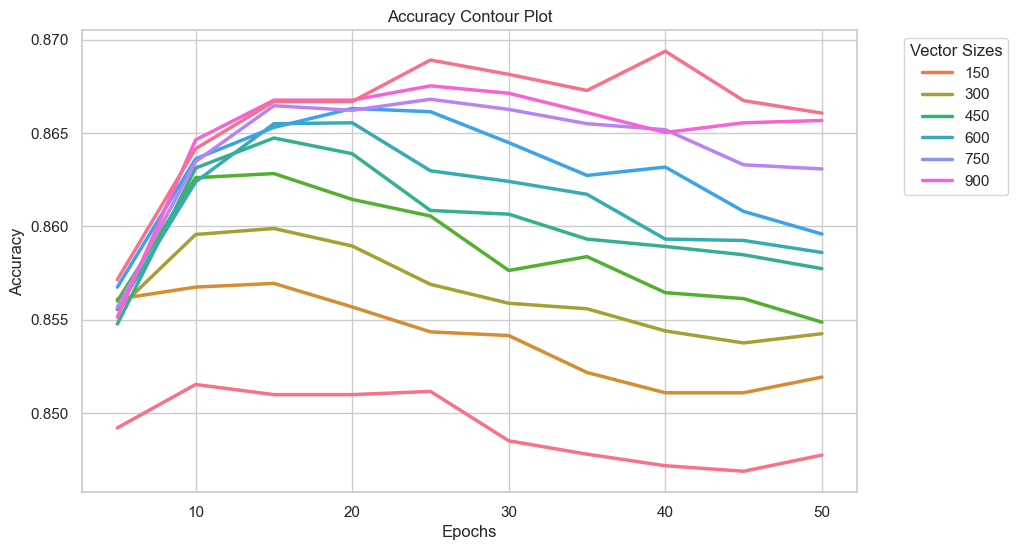

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reshape data for heatmap
heatmap_data = sg_trial.pivot(index="vector_sizes", columns="epochs", values="accuracy")

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu")
plt.title("Accuracy Heatmap")
plt.xlabel("Epochs")
plt.ylabel("Vector Sizes")
plt.show()

# Create contour plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=sg_trial, x='epochs', y='accuracy', hue='vector_sizes', palette="husl", linewidth=2.5)
plt.title("Accuracy Contour Plot")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(title='Vector Sizes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Model Testing
* `length` features:
    * None
    * MinMaxScaler
    * StandardScaler
* AvgWord2Vec:
    * Type:
        * skipgram: vector = 300, epochs = 15
        * cbow: vector = 200, epochs = 35
    * Window = 10
    * ngrams = (1, 1) or (1, 2) or (1, 3)
* Model
    * Logistic Regression (baseline)
    * LightGBM
    * Catboost
    * (KNN)
    * (SVM)
    * (XGBoost)
    * (GradientBoost)

### LogisticRegression

In [13]:
import time

output = {'length_used': [],
          'w2v_type': [],
          'vector_size': [],
          'epochs': [],
          'ngrams': [],
          'model': [],
          'accuracy': [],
          'f1': [],
          'recall': [],
          'precision': [],
          'roc_auc': []}

testcases = {'length_used': {'None': None,
                             'MinMaxScaler': MinMaxScaler(),
                             'StandardScaler': StandardScaler()},
             'type': {'skipgram': {'vector_size': 600, 'epochs': 15},
                      'cbow': {'vector_size': 300, 'epochs': 30}},
             'ngrams': [(1, 1), (1, 2), (1, 3)],
             'feature_extraction': 'Word2Vec(vector_size=300, window=10)',
             'feature selection': {'None': None},
             'model': {'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
                       'LightGBM': LGBMClassifier(random_state=42, verbose=False),
                       'Catboost': CatBoostClassifier(random_state=42, verbose=False),
                       'GradientBoost': GradientBoostingClassifier(random_state=42),
                       'XGBoost': XGBClassifier(random_state=42),
                       'AdaBoost': AdaBoostClassifier(random_state=42),
                       'KNN': KNeighborsClassifier(),
                       'SVM': SVC(probability=True)}}

testcases = {'length_used': {'None': None,
                             'MinMaxScaler': MinMaxScaler(),
                             'StandardScaler': StandardScaler()},
             'type': {'skipgram': {'vector_size': 300, 'epochs': 15},
                      'cbow': {'vector_size': 200, 'epochs': 35}},
             'ngrams': [(1, 1), (1, 2), (1, 3)],
             'feature_extraction': 'Word2Vec(vector_size=300, window=10)',
             'feature selection': {'None': None},
             'model': {'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
                       'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
                       'Catboost': CatBoostClassifier(random_state=42, silent=True)}}

for length in ['None']:
    if length == 'None':
        data = osf_cleaned.iloc[:, 1:].copy()
    else:
        data = osf_cleaned.copy()
    for n in [(1, 3)]:
        start = time.time()
        extractor = AvgWord2Vec(vector_size=600, window=10, ngram_range=n, sg=1, epochs=15)
        scores = multi_cross_validation(data=data,
                                        extractor=extractor,
                                        models=testcases['model'],
                                        length_scaler=testcases['length_used'][length], quiet=False)
        for model_name, model_scores in scores.items():
            output['length_used'].append(length)
            output['w2v_type'].append('skipgram')
            output['vector_size'].append(600)
            output['epochs'].append(15)
            output['ngrams'].append(n)
            output['model'].append(model_name)
            for method, score in model_scores.items():
                output[method].append(score)
            durations = time.time() - start
            print(f'length: {length} - skipgram - ngram: {n} - model: {model_name}: Done in {int(durations//60)}m{int(durations%60)}s')
        print()

round 1:
	Text extraction: Done in 38m31s
	Length scale: Done in 0m0s
	Dimensionality reduction: Done in 0m0s
	LogisticRegression - Modelling: Done in 0m3s
	Evaluation: Done in 0m0s
	LightGBM - Modelling: Done in 0m11s
	Evaluation: Done in 0m0s
	Catboost - Modelling: Done in 2m29s
	Evaluation: Done in 0m0s

round 2:
	Text extraction: Done in 68m43s
	Length scale: Done in 0m0s
	Dimensionality reduction: Done in 0m0s
	LogisticRegression - Modelling: Done in 0m3s
	Evaluation: Done in 0m0s
	LightGBM - Modelling: Done in 0m16s
	Evaluation: Done in 0m0s
	Catboost - Modelling: Done in 2m36s
	Evaluation: Done in 0m0s

round 3:


In [17]:
# output = {'length_used': [],
#           'w2v_type': [],
#           'vector_size': [],
#           'epochs': [],
#           'ngrams': [],
#           'model': [],
#           'accuracy': [],
#           'f1': [],
#           'recall': [],
#           'precision': [],
#           'roc_auc': []}

# for model_name, model_scores in scores.items():
#     output['length_used'].append(length)
#     output['w2v_type'].append('skipgram')
#     output['vector_size'].append(600)
#     output['epochs'].append(15)
#     output['ngrams'].append(n)
#     output['model'].append(model_name)
#     for method, score in model_scores.items():
#         output[method].append(score)

In [21]:
output_df = pd.DataFrame(output)
output_df
# output_df.to_csv("../../output/w2v_model.csv", index=False)

,length_used,w2v_type,vector_size,epochs,ngrams,model,accuracy,f1,recall,precision,roc_auc
0,None,skipgram,600,15,"(1, 2)",LogisticRegression,0.879798,0.881608,0.895219,0.868417,0.940922
1,None,skipgram,600,15,"(1, 2)",LightGBM,0.866220,0.872780,0.917313,0.832839,0.950212
2,None,skipgram,600,15,"(1, 2)",Catboost,0.886773,0.889617,0.912490,0.868241,0.957195


In [25]:
# output_df = pd.DataFrame(output)
# output_df
# output_saved = pd.read_csv("../../output/w2v_model.csv")
# output_saved
# output_new = pd.concat([output_saved, output_df], axis=0, ignore_index=True)
# output_new
# output_new.to_csv("../../output/w2v_model.csv", index=False)

In [52]:
output['notes'] = ['']*len(output['data'])
output_df = pd.DataFrame(output)
output_df
# output_df.to_csv(r"..\..\output\csv\word2vec_old.csv", index=False)

,data,length_used,ngrams,feature_extraction,feature_selection,model,accuracy,f1,recall,precision,roc_auc,notes
0,osf,"{'None': None, 'MinMaxScaler': MinMaxScaler(),...","(1, 1)","Word2Vec(vector_size=300, window=10)",None,LogisticRegression,0.851058,0.852018,0.857774,0.846356,0.914589,


In [ ]:
testcases = {'data': {'osf': osf_cleaned},
             'length_used': {'None': None},
             'feature_extraction': ['Word2Vec(vector_size={}, window={})'],
             'feature selection': {'None': None,
                                   'PCA': PCA,
                                   'SelectKBest(score_func={}, k={})': SelectKBest},
             'model': {'LogisticRegression(max_iter=1000, class_weight="balanced")': LogisticRegression(max_iter=1000, class_weight='balanced')}}

In [ ]:
output = {'data': [],
          'length_used': [],
          'feature_extraction': [],
          'feature_selection': [],
          'model': [],
          'accuracy': [],
          'f1': [],
          'recall': [],
          'precision': [],
          'roc_auc': [],
          'notes': []}

In [ ]:
# output = {'data': [],
#           'length_used': [],
#           'feature_extraction': [],
#           'feature_selection': [],
#           'model': [],
#           'accuracy': [],
#           'f1': [],
#           'recall': [],
#           'precision': [],
#           'roc_auc': [],
#           'notes': []}

# testcases = {'data': {'osf': osf_cleaned},
#              'length_used': {'None': None,
#                              'StandardScaler': StandardScaler(),
#                              'MinMaxScaler': MinMaxScaler()},
#              'feature_extraction': ['Word2Vec(vector_size={}, window={})'],
#              'feature selection': {'None': None},
#              'model': {'LogisticRegression(max_iter=1000, class_weight="balanced")': LogisticRegression(max_iter=1000, class_weight='balanced')}}

# for data_name in testcases['data']:
#     for length in testcases['length_used']:
#         if length == 'None':
#             data = testcases['data'][data_name].iloc[:, 1:].copy()
#         else:
#             data = testcases['data'][data_name].copy()
#         for size in np.arange(100, 1100, 100):
#             for window in range(3, 9, 2):
#                 extractor = Word2Vec(vector_size=size, window=window, workers=5, min_count=1, seed=42)
#                 for selector_name in testcases['feature selection']:
#                     selector = testcases['feature selection'][selector_name]
#                     for model_name in testcases['model']:
#                         model = testcases['model'][model_name]
#                         scores = cross_validation(data=data,
#                                                   length_scaler=testcases['length_used'][length],
#                                                   extractor=extractor,
#                                                   selector=selector,
#                                                   model=model)
                        
#                         output['data'].append(data_name)
#                         output['length_used'].append(length)
#                         output['feature_extraction'].append(f'Word2Vec(vector_size={size}, window={window})')
#                         output['feature_selection'].append(selector_name)
#                         output['model'].append(model_name)
#                         for key, values in scores.items():
#                             output[key].append(values)

output = {'data': [],
          'length_used': [],
          'feature_extraction': [],
          'feature_selection': [],
          'model': [],
          'accuracy': [],
          'f1': [],
          'recall': [],
          'precision': [],
          'roc_auc': [],
          'notes': []}

testcases = {'data': {'osf': osf_cleaned},
             'length_used': {'None': None},
             'feature_extraction': ['Word2Vec(vector_size={}, window={})'],
             'feature selection': {'None': None},
             'model': {'LogisticRegression(max_iter=1000, class_weight="balanced")': LogisticRegression(max_iter=1000, class_weight='balanced')}}

for data_name in testcases['data']:
    for length in testcases['length_used']:
        if length == 'None':
            data = testcases['data'][data_name].iloc[:, 1:].copy()
        else:
            data = testcases['data'][data_name].copy()
        for size in np.arange(700, 710, 100):
            for window in range(5, 9, 2):
                extractor = Word2Vec(vector_size=size, window=window, workers=5, min_count=1, seed=42, sg=1)
                for selector_name in testcases['feature selection']:
                    selector = testcases['feature selection'][selector_name]
                    for model_name in testcases['model']:
                        model = testcases['model'][model_name]
                        scores = cross_validation(data=data,
                                                  length_scaler=testcases['length_used'][length],
                                                  extractor=extractor,
                                                  selector=selector,
                                                  model=model)
                        
                        output['data'].append(data_name)
                        output['length_used'].append(length)
                        output['feature_extraction'].append(f'Word2Vec(vector_size={size}, window={window}, sg=1)')
                        output['feature_selection'].append(selector_name)
                        output['model'].append(model_name)
                        for key, values in scores.items():
                            output[key].append(values)

In [ ]:
output_saved = output.copy()
output_saved['notes'] = ['']*len(output_saved['data'])
# # pd.DataFrame(output_saved).to_csv("data/result/test_result.csv", index=False)

In [ ]:
output_saved_df = pd.DataFrame(output_saved)
output_saved_df

,data,length_used,feature_extraction,feature_selection,model,accuracy,f1,recall,precision,roc_auc,notes
0,osf,None,"Word2Vec(vector_size=700, window=5, sg=1)",None,"LogisticRegression(max_iter=1000, class_weight...",0.864736,0.865342,0.869477,0.861249,0.926651,
1,osf,None,"Word2Vec(vector_size=700, window=7, sg=1)",None,"LogisticRegression(max_iter=1000, class_weight...",0.863821,0.864472,0.868847,0.860146,0.926498,


In [ ]:
result = pd.read_csv('../../output/csv/word2vec.csv')
result = pd.concat([result, output_saved_df], axis=0, ignore_index=True)
# result.sort_values(by='accuracy', ascending=True)
# result[result['feature_extraction']=='Word2Vec(vector_size=100, window=5)']
result

,data,length_used,feature_extraction,feature_selection,model,accuracy,f1,recall,precision,roc_auc,notes
0,osf,NaN,"Word2Vec(vector_size=100, window=3)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.842649,0.843850,0.850587,0.837234,0.906563,NaN
1,osf,NaN,"Word2Vec(vector_size=100, window=5)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.847769,0.848826,0.855068,0.842681,0.911585,NaN
2,osf,NaN,"Word2Vec(vector_size=100, window=7)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.849649,0.850687,0.856728,0.844732,0.913208,NaN
3,osf,NaN,"Word2Vec(vector_size=200, window=3)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.852518,0.853635,0.860505,0.846878,0.915526,NaN
4,osf,NaN,"Word2Vec(vector_size=200, window=5)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.854348,0.855324,0.861271,0.849461,0.917639,NaN
...,...,...,...,...,...,...,...,...,...,...,...
106,osf,NaN,"Word2Vec(vector_size=600, window=5, sg=1)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.863796,0.864541,0.869531,0.859616,0.925525,NaN
107,osf,NaN,"Word2Vec(vector_size=600, window=7, sg=1)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.863029,0.863597,0.867322,0.859918,0.924754,NaN
108,osf,NaN,"Word2Vec(vector_size=700, window=3, sg=1)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.863326,0.864018,0.868673,0.859418,0.925477,NaN
109,osf,None,"Word2Vec(vector_size=700, window=5, sg=1)",None,"LogisticRegression(max_iter=1000, class_weight...",0.864736,0.865342,0.869477,0.861249,0.926651,


In [ ]:
# result.to_csv("../../output/csv/word2vec.csv", index=False)

In [ ]:
pd.read_csv(r"../../output/csv/word2vec.csv").head(20)

,data,length_used,feature_extraction,feature_selection,model,accuracy,f1,recall,precision,roc_auc,notes
0,osf,NaN,"Word2Vec(vector_size=100, window=3)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.842649,0.843850,0.850587,0.837234,0.906563,NaN
1,osf,NaN,"Word2Vec(vector_size=100, window=5)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.847769,0.848826,0.855068,0.842681,0.911585,NaN
2,osf,NaN,"Word2Vec(vector_size=100, window=7)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.849649,0.850687,0.856728,0.844732,0.913208,NaN
3,osf,NaN,"Word2Vec(vector_size=200, window=3)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.852518,0.853635,0.860505,0.846878,0.915526,NaN
4,osf,NaN,"Word2Vec(vector_size=200, window=5)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.854348,0.855324,0.861271,0.849461,0.917639,NaN
5,osf,NaN,"Word2Vec(vector_size=200, window=7)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.856302,0.857377,0.864039,0.850829,0.918628,NaN
6,osf,NaN,"Word2Vec(vector_size=300, window=3)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.856623,0.857629,0.863930,0.851424,0.919816,NaN
7,osf,NaN,"Word2Vec(vector_size=300, window=5)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.859517,0.860394,0.866098,0.854766,0.921931,NaN
8,osf,NaN,"Word2Vec(vector_size=300, window=7)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.859493,0.860598,0.867477,0.853828,0.922632,NaN
9,osf,NaN,"Word2Vec(vector_size=400, window=3)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.858973,0.859875,0.865743,0.854087,0.921766,NaN
